In [1]:
import numpy as np
import matplotlib.pyplot as plt
#pip install opencv-python
import cv2
from sklearn.cluster import DBSCAN

In [6]:
def cluster_gen(n_clusters, pts_minmax=(10,100), x_mult=(1,4), y_mult=(1,3), x_off=(0,50), y_off=(0,50)):
    clusters_x = []
    clusters_y = []
    n_points = np.random.randint(pts_minmax[0], pts_minmax[1], n_clusters)
    x_multipliers = np.random.randint(x_mult[0], x_mult[1], n_clusters)
    y_multipliers = np.random.randint(y_mult[0], y_mult[1], n_clusters)
    x_offsets = np.random.randint(x_off[0], x_off[1], n_clusters)
    y_offsets = np.random.randint(y_off[0], y_off[1], n_clusters)
    
    for idx, npts in enumerate(n_points):
        xpts = np.random.randn(npts) * x_multipliers[idx] + x_offsets[idx]
        ypts = np.random.randn(npts) * y_multipliers[idx] + y_offsets[idx]
        clusters_x.append(xpts)
        clusters_y.append(ypts)

    return clusters_x, clusters_y

In [7]:
n_clusters = 50
clusters_x, clusters_y = cluster_gen(n_clusters)

In [8]:
data = np.float32((np.concatenate(clusters_x), np.concatenate(clusters_y))).transpose()

In [11]:
max_distance = 1
db = DBSCAN(eps=max_distance, min_samples=10).fit(data)

In [12]:
core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

In [20]:
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

<AxesSubplot:>

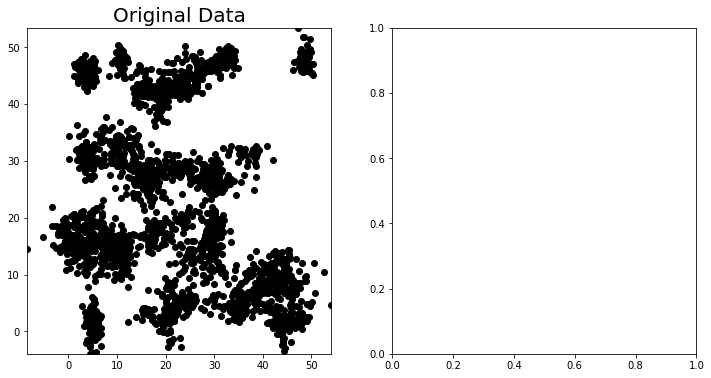

In [21]:
min_x = np.min(data[:,0])
max_x = np.max(data[:,0])
min_y = np.min(data[:,1])
max_y = np.max(data[:,1])

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(data[:,0], data[:,1], 'ko')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Original Data', fontsize = 20)

plt.subplot(122)

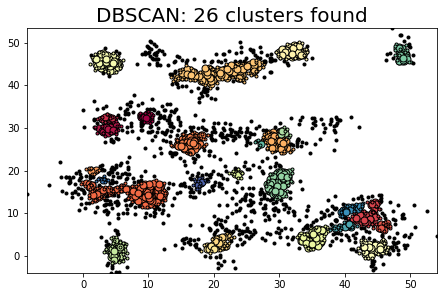

In [22]:
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0,0,0,1]
        
    class_member_mask = (labels == k)
    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=7)
    
    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=3)

plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('DBSCAN: %d clusters found' % n_clusters, fontsize = 20)
fig.tight_layout()
plt.subplots_adjust(left=0.03, right=0.98, top=0.9, bottom=0.05)

## DBSCAN in Supermarket Mall

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
df.rename(columns={'Genre': 'Gender'}, inplace=True)
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

<AxesSubplot:xlabel='Gender', ylabel='Spending Score (1-100)'>

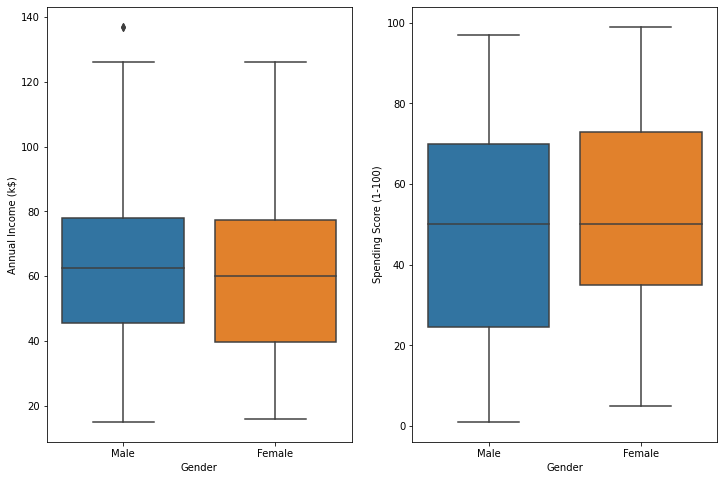

In [5]:
fig, axes = plt.subplots(1,2,figsize=(12,8))
sns.boxplot(x="Gender", y="Annual Income (k$)", data=df, orient='v', ax=axes[0])
sns.boxplot(x="Gender", y="Spending Score (1-100)", data=df, orient='v', ax=axes[1])

In [6]:
# groupby annual income dan spending berdasarkan gender
df_group_one = df[['Gender', 'Annual Income (k$)', 'Spending Score (1-100)']]
df_group_one.groupby(['Gender'], as_index=False).mean()

,Gender,Annual Income (k$),Spending Score (1-100)
0,Female,59.250000,51.526786
1,Male,62.227273,48.511364


In [7]:
df_female = df[df['Gender'] == "Female"]
print(df_female.shape)
df_female.head()

(112, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6


In [8]:
Percentage = (df_female.shape[0]/df.shape[0])*100
print('Female Percentage: ', round(Percentage), '%')

Female Percentage:  56 %


In [9]:
# Compute DBSCAN
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

Clus_dataSet = df_female[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = np.array(Clus_dataSet, dtype=np.float64)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

db = DBSCAN(eps=0.5, min_samples=4).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_female['Clus_Db'] = labels

realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

print(df_female[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Clus_Db']].head())

print("number of labels: ", set(labels))

   Age  Annual Income (k$)  Spending Score (1-100)  Clus_Db
2   20                  16                       6       -1
3   23                  16                      77        0
4   31                  17                      40       -1
5   22                  17                      76        0
6   35                  18                       6       -1
number of labels:  {0, 1, 2, 3, -1}


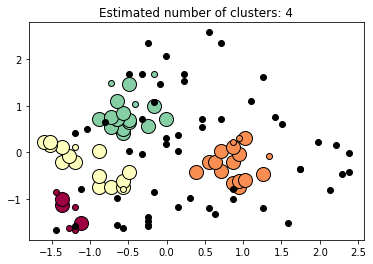

number of noise(s):  54


In [10]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
         for each in np.linspace(0,1,len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0,0,0,1]
        
    class_member_mask = (labels == k)
    
    xy = Clus_dataSet[class_member_mask & core_samples_mask]
    plt.plot(xy[:,0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=14)
    
    xy = Clus_dataSet[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:,0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % realClusterNum)
plt.show()

n_noise_ = list(labels).count(-1)
print('number of noise(s): ', n_noise_)

In [12]:
for clust_number in set(labels):
    clust_set = df_female[df_female.Clus_Db == clust_number]
    if clust_number != -1:
        print("Cluster "+ str(clust_number)+', Avg Age: '+ str(round(np.mean(clust_set.Age)))+\
             ', Avg Income')

Cluster 0, Avg Age: 22, Avg Income
Cluster 1, Avg Age: 49, Avg Income
Cluster 2, Avg Age: 25, Avg Income
Cluster 3, Avg Age: 32, Avg Income


## Association Learning – Apriori Algorithm

In [13]:
#pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [14]:
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

In [15]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Apple,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Unicorn,Yogurt
0,False,False,False,True,False,True,True,True,True,False,True
1,False,False,True,True,False,True,False,True,True,False,True
2,True,False,False,True,False,True,True,False,False,False,False
3,False,True,False,False,False,True,True,False,False,True,True
4,False,True,False,True,True,True,False,False,True,False,False


In [16]:
from mlxtend.frequent_patterns import apriori

apriori(df, min_support=0.6)

,support,itemsets
0,0.8,(3)
1,1.0,(5)
2,0.6,(6)
3,0.6,(8)
4,0.6,(10)
5,0.8,"(3, 5)"
6,0.6,"(8, 3)"
7,0.6,"(5, 6)"
8,0.6,"(8, 5)"
9,0.6,"(10, 5)"


In [17]:
apriori(df, min_support=0.6, use_colnames=True)

,support,itemsets
0,0.8,(Eggs)
1,1.0,(Kidney Beans)
2,0.6,(Milk)
3,0.6,(Onion)
4,0.6,(Yogurt)
5,0.8,"(Kidney Beans, Eggs)"
6,0.6,"(Onion, Eggs)"
7,0.6,"(Kidney Beans, Milk)"
8,0.6,"(Onion, Kidney Beans)"
9,0.6,"(Kidney Beans, Yogurt)"


In [18]:
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.8,(Eggs),1
1,1.0,(Kidney Beans),1
2,0.6,(Milk),1
3,0.6,(Onion),1
4,0.6,(Yogurt),1
5,0.8,"(Kidney Beans, Eggs)",2
6,0.6,"(Onion, Eggs)",2
7,0.6,"(Kidney Beans, Milk)",2
8,0.6,"(Onion, Kidney Beans)",2
9,0.6,"(Kidney Beans, Yogurt)",2


In [19]:
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.8) ]

,support,itemsets,length
5,0.8,"(Kidney Beans, Eggs)",2


In [20]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Onion', 'Eggs'} ]

,support,itemsets,length
6,0.6,"(Onion, Eggs)",2


## Association Learning – FP Growth Algorithm

In [21]:
from mlxtend.frequent_patterns import fpgrowth

fpgrowth(df, min_support=0.6)

,support,itemsets
0,1.0,(5)
1,0.8,(3)
2,0.6,(10)
3,0.6,(8)
4,0.6,(6)
5,0.8,"(3, 5)"
6,0.6,"(10, 5)"
7,0.6,"(8, 3)"
8,0.6,"(8, 5)"
9,0.6,"(8, 3, 5)"


In [22]:
fpgrowth(df, min_support=0.6, use_colnames=True)

,support,itemsets
0,1.0,(Kidney Beans)
1,0.8,(Eggs)
2,0.6,(Yogurt)
3,0.6,(Onion)
4,0.6,(Milk)
5,0.8,"(Kidney Beans, Eggs)"
6,0.6,"(Kidney Beans, Yogurt)"
7,0.6,"(Onion, Eggs)"
8,0.6,"(Onion, Kidney Beans)"
9,0.6,"(Onion, Kidney Beans, Eggs)"


In [23]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [24]:
from mlxtend.frequent_patterns import apriori

%timeit -n 100 -r 10 apriori(df, min_support=0.6)

9.03 ms ± 1.17 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [26]:
from mlxtend.frequent_patterns import fpgrowth

%timeit -n 100 -r 10 fpgrowth(df, min_support=0.6)

3.05 ms ± 351 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
